# case1 (logistic regression)

In [46]:
from sklearn import linear_model, grid_search, cross_validation, metrics, preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [47]:
def enumerate_not_nan_feature_values(data, feature, inplace=False):
    not_nan_feature_values = data[pd.notnull(data[feature])][feature]
    feature_values = list(set(not_nan_feature_values.values))
    if inplace:
        data.loc[not_nan_feature_values.index, feature] = not_nan_feature_values.map(lambda el: feature_values.index(el))
    else:
        return not_nan_feature_values.map(lambda el: feature_values.index(el))

In [48]:
train_data = pd.read_csv("data/titanic.csv", index_col="PassengerId")
train_data.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [49]:
imputer = preprocessing.Imputer()

# fill nan "Age" feature
train_data["Age"] = imputer.fit_transform(train_data["Age"].values.reshape(-1, 1)).astype(int)

# enumerate and fill nan "Embarked" feature
enumerate_not_nan_feature_values(train_data, "Embarked", True)
train_data["Embarked"] = imputer.fit_transform(train_data["Embarked"].values.reshape(-1, 1)).astype(int)

# enumerate "Sex" feature
enumerate_not_nan_feature_values(train_data, "Sex", True)

train_data, train_labels = train_data[train_data.columns[1:]].values, train_data.Survived.values

In [50]:
trainX, testX, trainY, testY = cross_validation.train_test_split(train_data, train_labels, test_size=0.3)

In [51]:
scaler = preprocessing.StandardScaler()
scaler.fit(trainX, trainY)
scaled_trainX, scaled_testX = scaler.transform(trainX), scaler.transform(testX)

In [52]:
%%time
params_grid = {
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag"],
    "C": np.linspace(0.25, 2, 15),
    "tol": np.linspace(0.0001, 0.5, 20)
}

lrc1 = linear_model.LogisticRegression()
lrc2 = linear_model.LogisticRegression()
lrc3 = linear_model.LogisticRegression(max_iter=10000)

gs1 = grid_search.GridSearchCV(lrc3, params_grid, cv=4)
gs2 = grid_search.GridSearchCV(lrc3, params_grid, cv=4)

scoresY = lrc1.fit(trainX, trainY).decision_function(testX)
scaled_scoresY = lrc2.fit(scaled_trainX, trainY).decision_function(scaled_testX)
gs_not_scaled_scoresY = gs1.fit(trainX, trainY).decision_function(testX)
gs_scaled_scoresY = gs2.fit(scaled_trainX, trainY).decision_function(scaled_testX)

CPU times: user 1min 43s, sys: 813 ms, total: 1min 44s
Wall time: 1min 46s


In [53]:
predictedY = lrc1.predict(testX)
scaled_features_predictedY = lrc2.predict(scaled_testX)
gs_not_scaled_predictedY = gs1.predict(testX)
gs_scaled_predictedY = gs2.predict(scaled_testX)

target_names = ["not survived", "survived"]

print("Not scaled data:")
print(metrics.classification_report(testY, predictedY, target_names=target_names))

print("Scaled data:")
print(metrics.classification_report(testY, scaled_features_predictedY, target_names=target_names))

print("Grid search with not scaled data:")
print(metrics.classification_report(testY, gs_not_scaled_predictedY, target_names=target_names))

print("Grid search with scaled data:")
print(metrics.classification_report(testY, gs_scaled_predictedY, target_names=target_names))

Not scaled data:
              precision    recall  f1-score   support

not survived       0.84      0.82      0.83       171
    survived       0.69      0.72      0.71        97

 avg / total       0.79      0.78      0.78       268

Scaled data:
              precision    recall  f1-score   support

not survived       0.84      0.80      0.82       171
    survived       0.67      0.74      0.71        97

 avg / total       0.78      0.78      0.78       268

Grid search with not scaled data:
              precision    recall  f1-score   support

not survived       0.84      0.80      0.82       171
    survived       0.68      0.73      0.70        97

 avg / total       0.78      0.78      0.78       268

Grid search with scaled data:
              precision    recall  f1-score   support

not survived       0.84      0.81      0.82       171
    survived       0.69      0.72      0.70        97

 avg / total       0.78      0.78      0.78       268



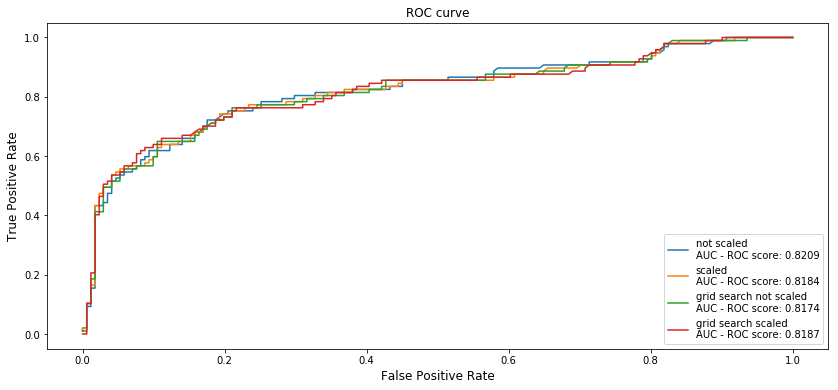

In [54]:
fpr, tpr, _ = metrics.roc_curve(testY, scoresY)
fpr_scaled, tpr_scaled, _ = metrics.roc_curve(testY, scaled_scoresY)
fpr_gs_not_scaled, tpr_gs_not_scaled, _ = metrics.roc_curve(testY, gs_not_scaled_scoresY)
fpr_gs_scaled, tpr_gs_scaled, _ = metrics.roc_curve(testY, gs_scaled_scoresY)

plt.figure(figsize=(14, 6))
plt.plot(fpr, tpr, label="not scaled\nAUC - ROC score: %.4f" % metrics.roc_auc_score(testY, scoresY))
plt.plot(fpr_scaled, tpr_scaled,
         label="scaled\nAUC - ROC score: %.4f" % metrics.roc_auc_score(testY, scaled_scoresY))
plt.plot(fpr_gs_not_scaled, tpr_gs_not_scaled,
         label="grid search not scaled\nAUC - ROC score: %.4f" % metrics.roc_auc_score(testY, gs_not_scaled_scoresY))
plt.plot(fpr_gs_scaled, tpr_gs_scaled,
         label="grid search scaled\nAUC - ROC score: %.4f" % metrics.roc_auc_score(testY, gs_scaled_scoresY))
plt.title("ROC curve")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.show()

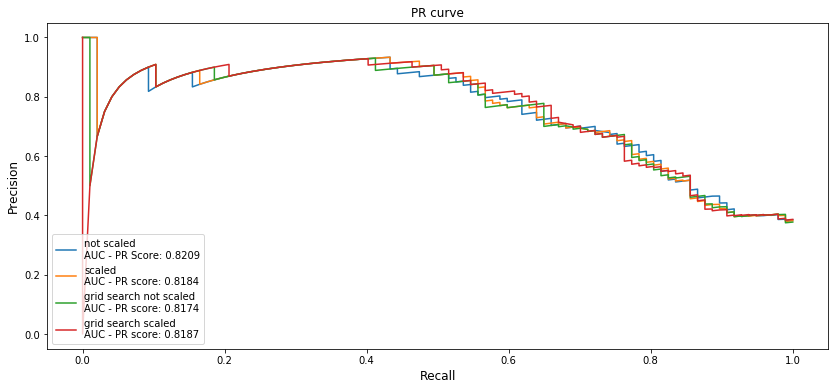

In [55]:
precision, recall, _ = metrics.precision_recall_curve(testY, scoresY)
precision_scaled, recall_scaled, _ = metrics.precision_recall_curve(testY, scaled_scoresY)
precision_gs_not_scaled, recall_gs_not_scaled, _ = metrics.precision_recall_curve(testY, gs_not_scaled_scoresY)
precision_gs_scaled, recall_gs_scaled, _ = metrics.precision_recall_curve(testY, gs_scaled_scoresY)

plt.figure(figsize=(14, 6))
plt.plot(recall, precision, label="not scaled\nAUC - PR Score: %.4f" % metrics.auc(fpr, tpr))
plt.plot(recall_scaled, precision_scaled, label="scaled\nAUC - PR score: %.4f" % metrics.auc(fpr_scaled, tpr_scaled))
plt.plot(recall_gs_not_scaled, precision_gs_not_scaled,
         label="grid search not scaled\nAUC - PR score: %.4f" % metrics.auc(fpr_gs_not_scaled, tpr_gs_not_scaled))
plt.plot(recall_gs_scaled, precision_gs_scaled,
         label="grid search scaled\nAUC - PR score: %.4f" % metrics.auc(fpr_gs_scaled, tpr_gs_scaled))
plt.title("PR curve")
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(loc="lower left")
plt.show()

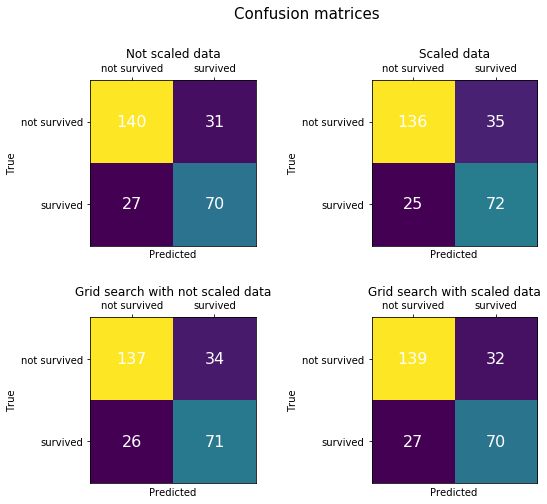

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(wspace=0.7)

labels = ["not survived", "survived"]

cm = metrics.confusion_matrix(testY, predictedY)
cm_scaled = metrics.confusion_matrix(testY, scaled_features_predictedY)
cm_grid_search_not_scaled = metrics.confusion_matrix(testY, gs_not_scaled_predictedY)
cm_grid_search_scaled = metrics.confusion_matrix(testY, gs_scaled_predictedY)

colobars = []
cax = axes[0, 0].imshow(cm, interpolation="nearest")
cax_scaled = axes[0, 1].imshow(cm_scaled, interpolation="nearest")
cax_grid_search_not_scaled = axes[1, 0].imshow(cm_grid_search_not_scaled, interpolation="nearest")
cax_grid_search_scaled = axes[1, 1].imshow(cm_grid_search_scaled, interpolation="nearest")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[0, 0].annotate(cm[i, j], xy=(j, i),
                      horizontalalignment="center",
                      verticalalignment="center",
                      fontsize=16, color="w")
        
for i in range(cm_scaled.shape[0]):
    for j in range(cm_scaled.shape[1]):
        axes[0, 1].annotate(cm_scaled[i, j], xy=(j, i),
                      horizontalalignment="center",
                      verticalalignment="center",
                      fontsize=16, color="w")
        
for i in range(cm_grid_search_not_scaled.shape[0]):
    for j in range(cm_grid_search_not_scaled.shape[1]):
        axes[1, 0].annotate(cm_grid_search_not_scaled[i, j], xy=(j, i),
                      horizontalalignment="center",
                      verticalalignment="center",
                      fontsize=16, color="w")

for i in range(cm_grid_search_scaled.shape[0]):
    for j in range(cm_grid_search_scaled.shape[1]):
        axes[1, 1].annotate(cm_grid_search_scaled[i, j], xy=(j, i),
                      horizontalalignment="center",
                      verticalalignment="center",
                      fontsize=16, color="w")

fig.suptitle("Confusion matrices", fontsize=15)
        
axes[0, 0].set_title("Not scaled data", y=1.1)
axes[0, 0].xaxis.tick_top()
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_yticks([0, 1])
axes[0, 0].set_xticklabels(labels)
axes[0, 0].set_yticklabels(labels)
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("True")

axes[0, 1].set_title("Scaled data", y=1.1)
axes[0, 1].xaxis.tick_top()
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_yticks([0, 1])
axes[0, 1].set_xticklabels(labels)
axes[0, 1].set_yticklabels(labels)
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("True")

axes[1, 0].set_title("Grid search with not scaled data", y=1.1)
axes[1, 0].xaxis.tick_top()
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_xticklabels(labels)
axes[1, 0].set_yticklabels(labels)
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("True")

axes[1, 1].set_title("Grid search with scaled data", y=1.1)
axes[1, 1].xaxis.tick_top()
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_xticklabels(labels)
axes[1, 1].set_yticklabels(labels)
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("True")

plt.show()

# case2 (Random forest with cross validation)

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from IPython.display import display, Image
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [92]:
voice_data = pd.read_csv('data/voice.csv')

In [93]:
voice_data.loc[voice_data['label'] == 'male', 'label'] = 0
voice_data.loc[voice_data['label'] == 'female', 'label'] = 1

In [94]:
X_male = voice_data.loc[voice_data['label'] == 0, 'label'].index.tolist()
X_female = voice_data.loc[voice_data['label'] == 1, 'label'].index.tolist()

('male median frequency', '\t\tfemale median frequency')
(176.343411359207, '\t\t', 192.73180501243604)


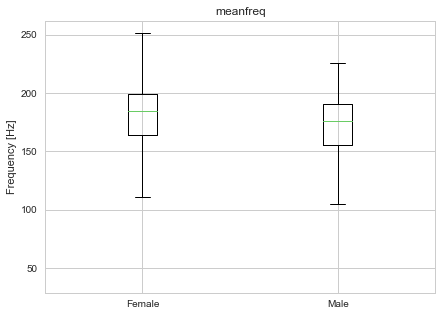

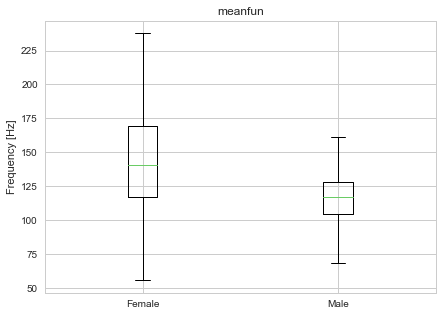

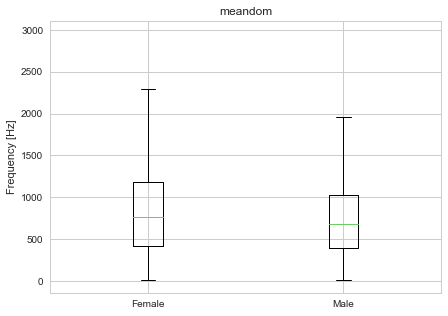

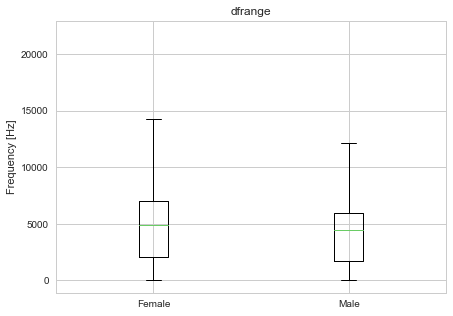

In [95]:
# Visualize some of the features which you expect to be most distinguishing

sd = voice_data['sd']
male_voicedata = voice_data['meanfreq'][X_male]
female_voicedata = voice_data['meanfreq'][X_female]

# Mean Frequency Plots
feature = 'meanfreq'
fig_meanfreq = plt.figure(figsize=(7,5))
ax = fig_meanfreq.add_subplot(111)
bp = ax.boxplot([voice_data[feature]*1000, voice_data[feature][X_male]*1000])
ax.set_xticklabels(['Female', 'Male'])
plt.title(feature)
plt.ylabel('Frequency [Hz]')

# Mean Fundamental Frequency Plots
feature = 'meanfun'
fig_meanfreq = plt.figure(figsize=(7,5))
ax = fig_meanfreq.add_subplot(111)
bp = ax.boxplot([voice_data[feature]*1000, voice_data[feature][X_male]*1000])
ax.set_xticklabels(['Female', 'Male'])
plt.title(feature)
plt.ylabel('Frequency [Hz]')


# Mean Dominant Frequency Plots
feature = 'meandom'
fig_meanfreq = plt.figure(figsize=(7,5))
ax = fig_meanfreq.add_subplot(111)
bp = ax.boxplot([voice_data[feature]*1000, voice_data[feature][X_male]*1000])
ax.set_xticklabels(['Female', 'Male'])
plt.title(feature)
plt.ylabel('Frequency [Hz]')


# Mean Dominant Frequency Plots
feature = 'dfrange'
fig_meanfreq = plt.figure(figsize=(7,5))
ax = fig_meanfreq.add_subplot(111)
bp = ax.boxplot([voice_data[feature]*1000, voice_data[feature][X_male]*1000])
ax.set_xticklabels(['Female', 'Male'])
plt.title(feature)
plt.ylabel('Frequency [Hz]')


print('male median frequency', '\t\tfemale median frequency')
print(male_voicedata.median()*1000,'\t\t', female_voicedata.median()*1000)

In [97]:
# Train a random forrest classifier using cross validation
# Use all predictors

# If we predict on fudamental frequency alone we can achieve ~ 95% accuaracy
#predictors = ['meanfun']

# Using all features we can achieve ~ 98% accuaracy
predictors = [
              'meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
              'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
              'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx'
             ]


alg = RandomForestClassifier( n_estimators=35, min_samples_split=3, min_samples_leaf=5)
kf = cross_validation.KFold(voice_data.shape[0],n_folds=10, shuffle=True)
scores = cross_validation.cross_val_score(alg, voice_data[predictors], list(voice_data['label']), cv = kf)
print(scores.mean())

ValueError: Unknown label type: 'unknown'

# case3 (logistic regression)

In [ ]:
import pandas as pd

def runCVforPatient(patientNo):
    
    data = pd.read_csv('train_' + str(patientNo) + '_features.csv') 
    
    data.sort_values(['outcome', 'segment'], inplace = True)
    data['seq'] = (data.sequence == 6).shift(1).fillna(0).cumsum()
    data.drop(['sequence'], axis=1, inplace=True)
       
    seq_outcome = data[['seq', 'outcome']].drop_duplicates()
    
    skf = StratifiedKFold(seq_outcome['outcome'], n_folds=5, random_state=1)
    AUC = []
    predictions = np.zeros([data.shape[0]])
    for train_index, test_index in skf:
        seq_train = np.array(seq_outcome.iloc[train_index]['seq'])
        seq_test = np.array(seq_outcome.iloc[test_index]['seq'])
        
        train_data = data[data.seq.isin(seq_train)]
        test_data = data[data.seq.isin(seq_test)]
        
        X_train = train_data.drop(['patient', 'segment', 'outcome', 'seq'], axis=1)
        y_train = train_data['outcome']
        X_test = test_data.drop(['patient', 'segment', 'outcome', 'seq'], axis=1)
        y_test = test_data['outcome']
        
        predictions_indexes = np.array(y_test.index)
        
        clf = LogisticRegression(C=20, n_jobs=-1, verbose=0)
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)
        this_AUC = roc_auc_score(y_test, y_pred[:,1])
        print ("AUC: " + str(this_AUC))
        AUC.append(this_AUC)
        
        predictions[predictions_indexes] = y_pred[:,1]
    
    print (np.mean(AUC), AUC)
    patient_predictions = pd.DataFrame(predictions)
    patient_predictions = patient_predictions.join(data[['outcome']])
    patient_predictions.columns = ['prediction', 'outcome']
    
    return patient_predictions

#Example (I comment it so it does not return errors):

#all_patient_predictions = pd.DataFrame()
#for patientNo in [1, 2, 3]:
#    patient_predictions = runCVforPatient(patientNo)
#    all_patient_predictions = pd.concat([all_patient_predictions, patient_predictions])
#    
#total_AUC = roc_auc_score(all_patient_predictions['outcome'], all_patient_predictions['prediction'])

# Feat_select(corr,rfe,rfecv,PCA)Seaborn,RandForest

In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf8"))

20news-bydate-train
CUST_VIP_demo_origin.csv
Cathay_SNA_demo.csv
MovieGenre.csv
MovieGenre.csv.zip
VS14MORT.txt
balance-scale.csv
births_train.csv
breast.csv
busan.txt
busan_edge.csv
busan_node.csv
credit_count.txt
creditcard.csv
dataconf.txt
dict.txt
event_relation.tsv
final_dict_pd.csv
ginal.csv
international-airline-passengers.csv
liquor.csv
lucy.txt
moviedata.csv
new_final_dict_pd.csv
origin_new.csv
people_event.tsv
planet.csv
series1.csv
shun.csv
test_final.csv
this.csv
this2.csv
titanic.csv
train_users.csv
train_v2.csv
yelp_academic_dataset_review.json



In [59]:
data = pd.read_csv('data/breast.csv')

In [60]:
data.head()  # head method show only first 5 rows

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [61]:
# feature names as a list
col = data.columns       # .columns gives columns names in data 
print(col)

Index([u'id', u'diagnosis', u'radius_mean', u'texture_mean', u'perimeter_mean',
       u'area_mean', u'smoothness_mean', u'compactness_mean',
       u'concavity_mean', u'concave points_mean', u'symmetry_mean',
       u'fractal_dimension_mean', u'radius_se', u'texture_se', u'perimeter_se',
       u'area_se', u'smoothness_se', u'compactness_se', u'concavity_se',
       u'concave points_se', u'symmetry_se', u'fractal_dimension_se',
       u'radius_worst', u'texture_worst', u'perimeter_worst', u'area_worst',
       u'smoothness_worst', u'compactness_worst', u'concavity_worst',
       u'concave points_worst', u'symmetry_worst', u'fractal_dimension_worst',
       u'Unnamed: 32'],
      dtype='object')


In [62]:
# y includes our labels and x includes our features
y = data.diagnosis                          # M or B 
list = ['Unnamed: 32','id','diagnosis']
x = data.drop(list,axis = 1 )
x.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


('Number of Benign: ', 357)
('Number of Malignant : ', 212)


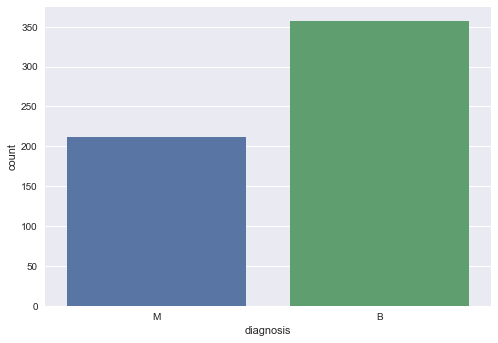

In [63]:
ax = sns.countplot(y,label="Count")       # M = 212, B = 357
B, M = y.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

In [64]:
x.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

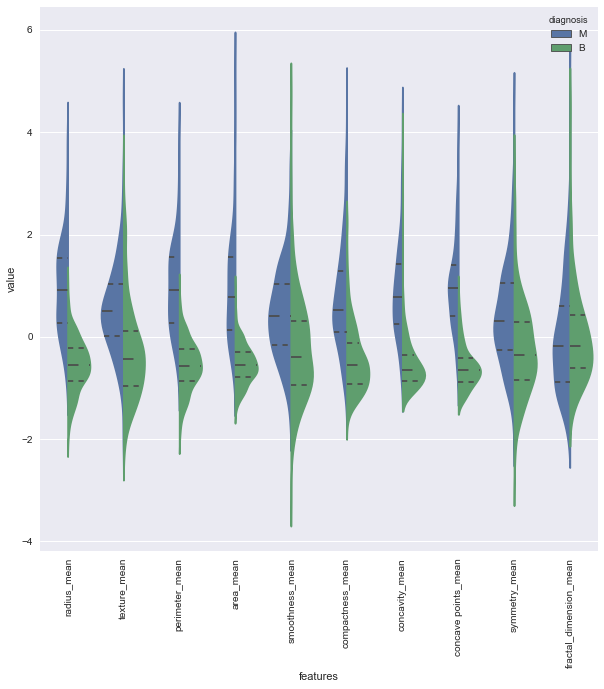

In [65]:
# first ten features
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([y,data_n_2.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

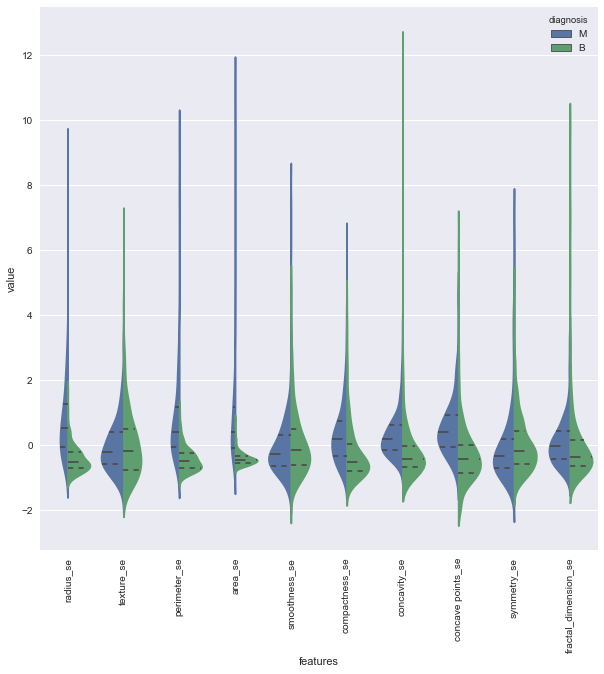

In [66]:
# Second ten features
data = pd.concat([y,data_n_2.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

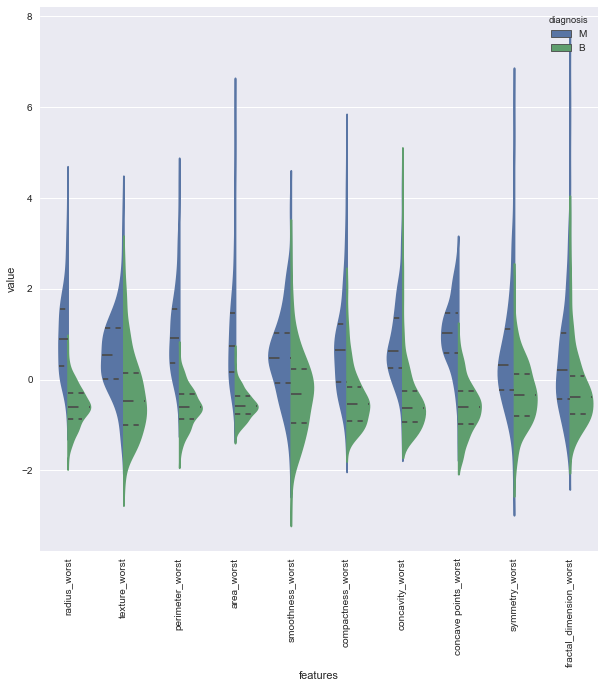

In [67]:
# Second ten features
data = pd.concat([y,data_n_2.iloc[:,20:31]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

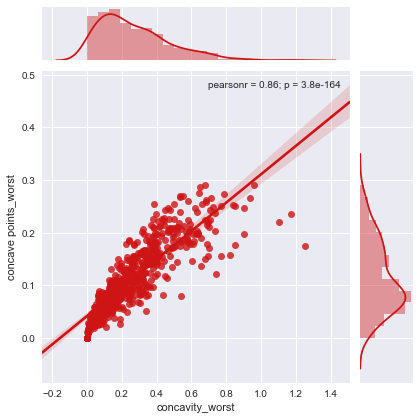

In [68]:
sns.jointplot(x.loc[:,'concavity_worst'], x.loc[:,'concave points_worst'], kind="regg", color="#ce1414")

/Users/bgg/training_course/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


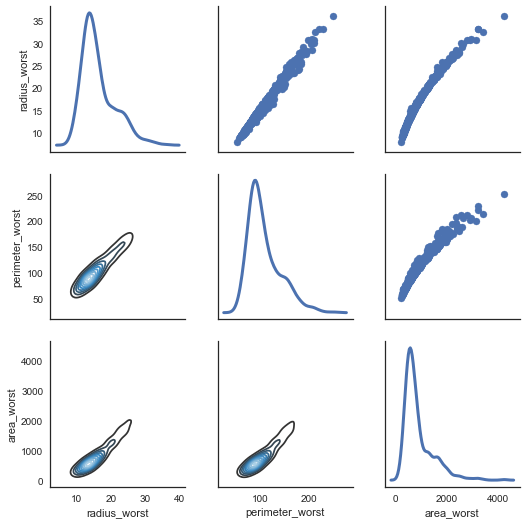

In [69]:
sns.set(style="white")
df = x.loc[:,['radius_worst','perimeter_worst','area_worst']]
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

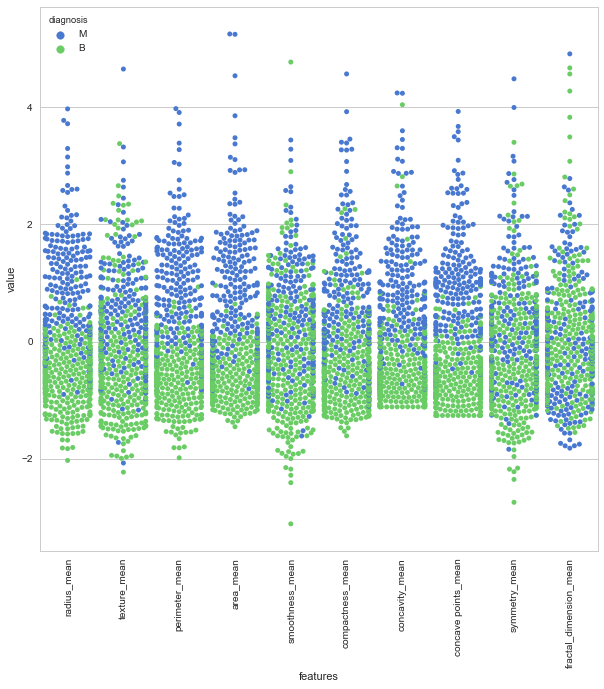

In [70]:
sns.set(style="whitegrid", palette="muted")
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([y,data_n_2.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

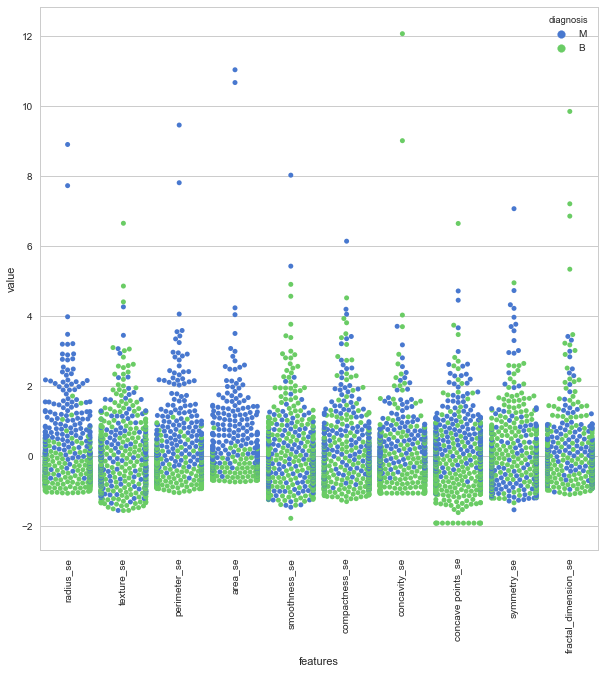

In [71]:
data = pd.concat([y,data_n_2.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

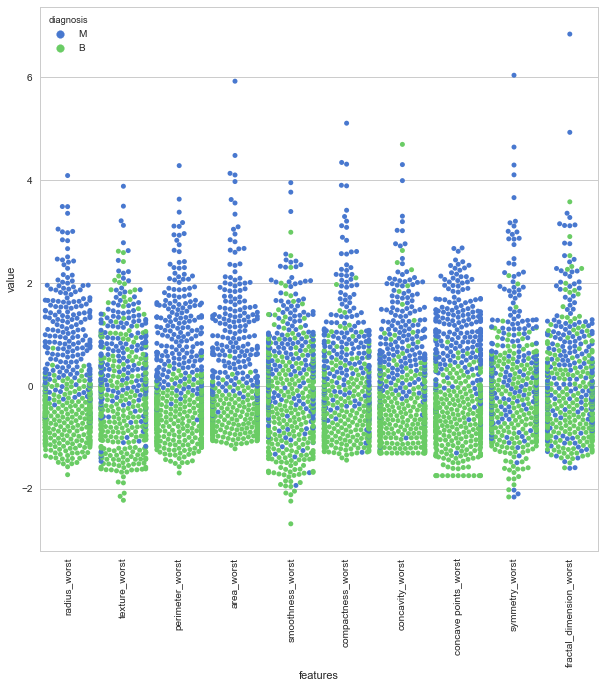

In [72]:
data = pd.concat([y,data_n_2.iloc[:,20:31]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=90)

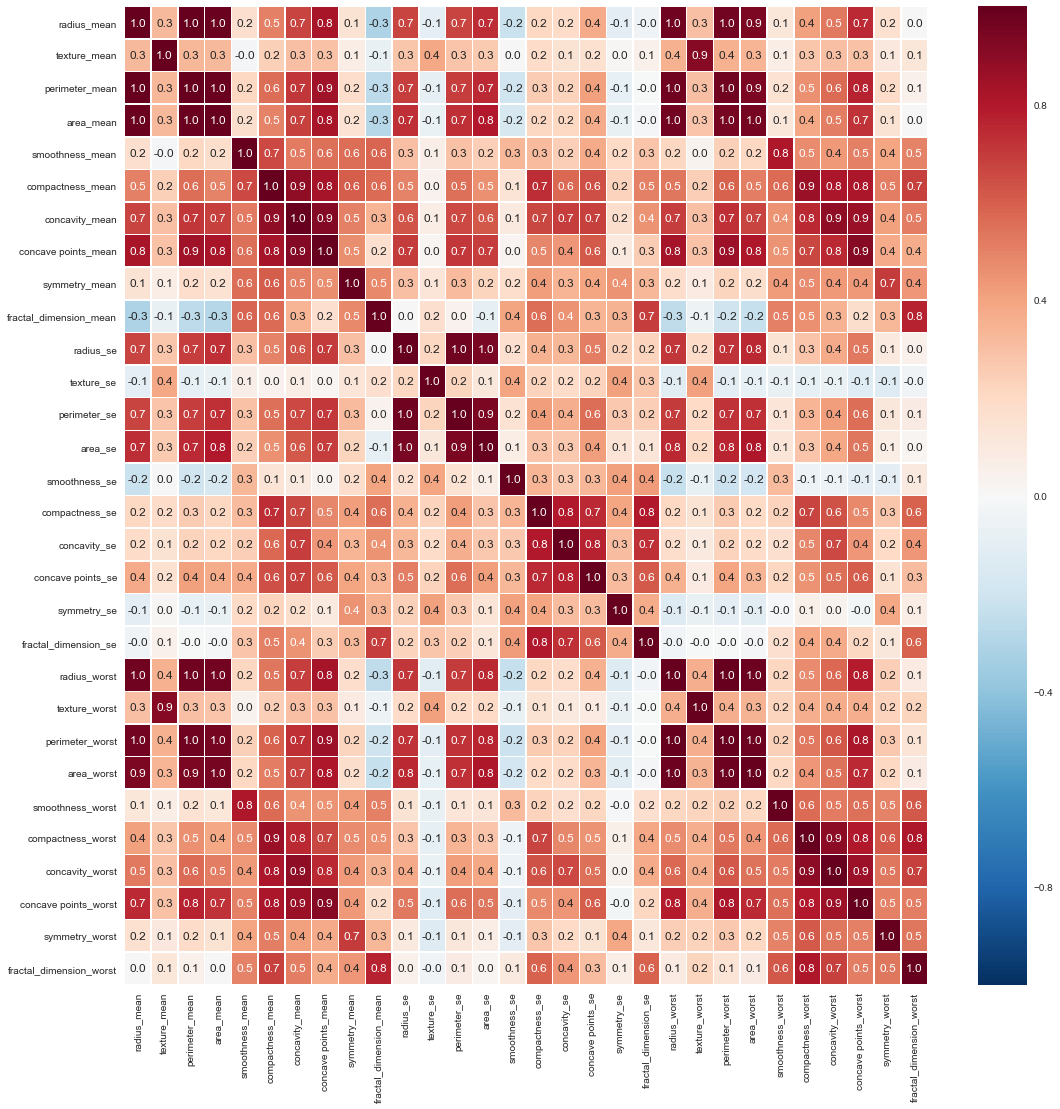

In [73]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [74]:
drop_list1 = ['perimeter_mean','radius_mean','compactness_mean','concave points_mean','radius_se','perimeter_se','radius_worst','perimeter_worst','compactness_worst','concave points_worst','compactness_se','concave points_se','texture_worst','area_worst']
x_1 = x.drop(drop_list1,axis = 1 )        # do not modify x, we will use it later 
x_1.head()

,texture_mean,area_mean,smoothness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,concavity_se,symmetry_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,10.38,1001.0,0.11840,0.3001,0.2419,0.07871,0.9053,153.40,0.006399,0.05373,0.03003,0.006193,0.1622,0.7119,0.4601,0.11890
1,17.77,1326.0,0.08474,0.0869,0.1812,0.05667,0.7339,74.08,0.005225,0.01860,0.01389,0.003532,0.1238,0.2416,0.2750,0.08902
2,21.25,1203.0,0.10960,0.1974,0.2069,0.05999,0.7869,94.03,0.006150,0.03832,0.02250,0.004571,0.1444,0.4504,0.3613,0.08758
3,20.38,386.1,0.14250,0.2414,0.2597,0.09744,1.1560,27.23,0.009110,0.05661,0.05963,0.009208,0.2098,0.6869,0.6638,0.17300
4,14.34,1297.0,0.10030,0.1980,0.1809,0.05883,0.7813,94.44,0.011490,0.05688,0.01756,0.005115,0.1374,0.4000,0.2364,0.07678


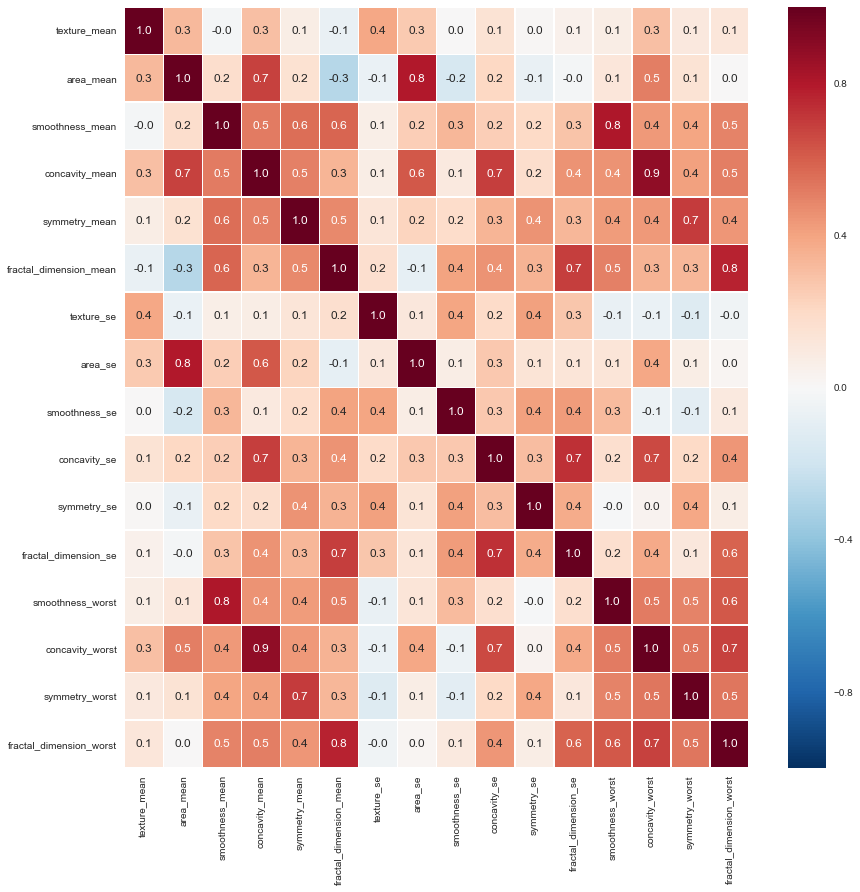

In [75]:
#correlation map
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(x_1.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

('Accuracy is: ', 0.95906432748538006)


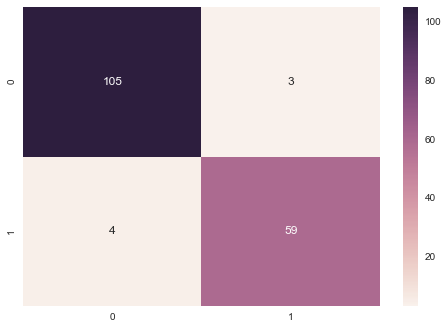

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x_1, y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier()      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

In [77]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# find best scored 5 features
select_feature = SelectKBest(chi2, k=5).fit(x_train, y_train)

In [78]:
print('Score list:', select_feature.scores_)
print('Feature list:', x_train.columns)

('Score list:', array([  6.06916433e+01,   3.66899557e+04,   1.00015175e-01,
         1.30547650e+01,   1.95982847e-01,   3.42575072e-04,
         4.07131026e-02,   6.12741067e+03,   1.32470372e-03,
         6.92896719e-01,   1.39557806e-03,   2.65927071e-03,
         2.63226314e-01,   2.58858117e+01,   1.00635138e+00,
         1.23087347e-01]))
('Feature list:', Index([u'texture_mean', u'area_mean', u'smoothness_mean', u'concavity_mean',
       u'symmetry_mean', u'fractal_dimension_mean', u'texture_se', u'area_se',
       u'smoothness_se', u'concavity_se', u'symmetry_se',
       u'fractal_dimension_se', u'smoothness_worst', u'concavity_worst',
       u'symmetry_worst', u'fractal_dimension_worst'],
      dtype='object'))


('Accuracy is: ', 0.96491228070175439)


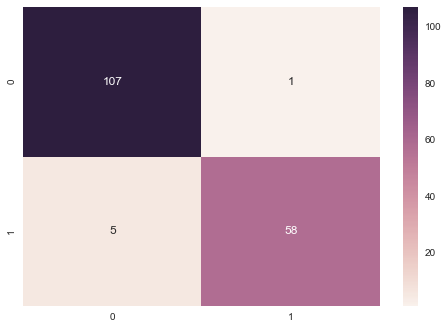

In [79]:
x_train_2 = select_feature.transform(x_train)
x_test_2 = select_feature.transform(x_test)
#random forest classifier with n_estimators=10 (default)
clf_rf_2 = RandomForestClassifier()      
clr_rf_2 = clf_rf_2.fit(x_train_2,y_train)
ac_2 = accuracy_score(y_test,clf_rf_2.predict(x_test_2))
print('Accuracy is: ',ac_2)
cm_2 = confusion_matrix(y_test,clf_rf_2.predict(x_test_2))
sns.heatmap(cm_2,annot=True,fmt="d")

In [80]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=5, step=1)
rfe = rfe.fit(x_train, y_train)

In [81]:
print('Chosen best 5 feature by rfe:',x_train.columns[rfe.support_])

('Chosen best 5 feature by rfe:', Index([u'area_mean', u'concavity_mean', u'area_se', u'concavity_worst',
       u'symmetry_worst'],
      dtype='object'))


In [82]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

('Optimal number of features :', 8)
('Best features :', Index([u'texture_mean', u'area_mean', u'concavity_mean', u'area_se',
       u'concavity_se', u'symmetry_se', u'concavity_worst', u'symmetry_worst'],
      dtype='object'))


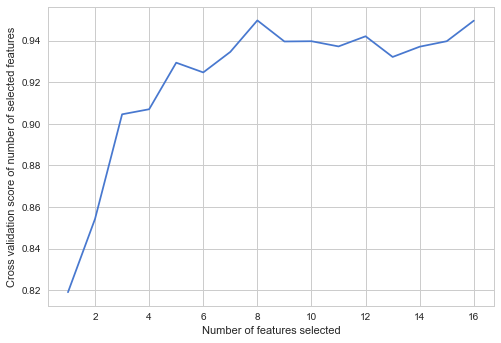

In [83]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Feature ranking:
1. feature 3 (0.298955)
2. feature 1 (0.193438)
3. feature 7 (0.192931)
4. feature 13 (0.063251)
5. feature 0 (0.050968)
6. feature 14 (0.041584)
7. feature 12 (0.030101)
8. feature 2 (0.021894)
9. feature 5 (0.021722)
10. feature 11 (0.021139)
11. feature 9 (0.014534)
12. feature 4 (0.012176)
13. feature 10 (0.010822)
14. feature 6 (0.009189)
15. feature 15 (0.009064)
16. feature 8 (0.008232)


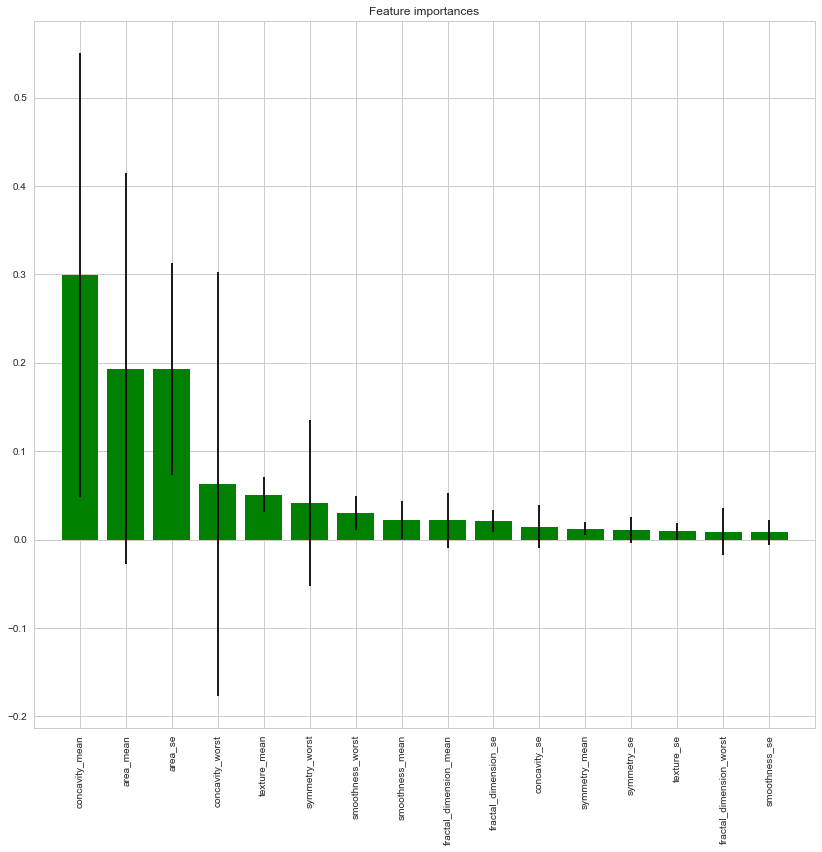

In [84]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

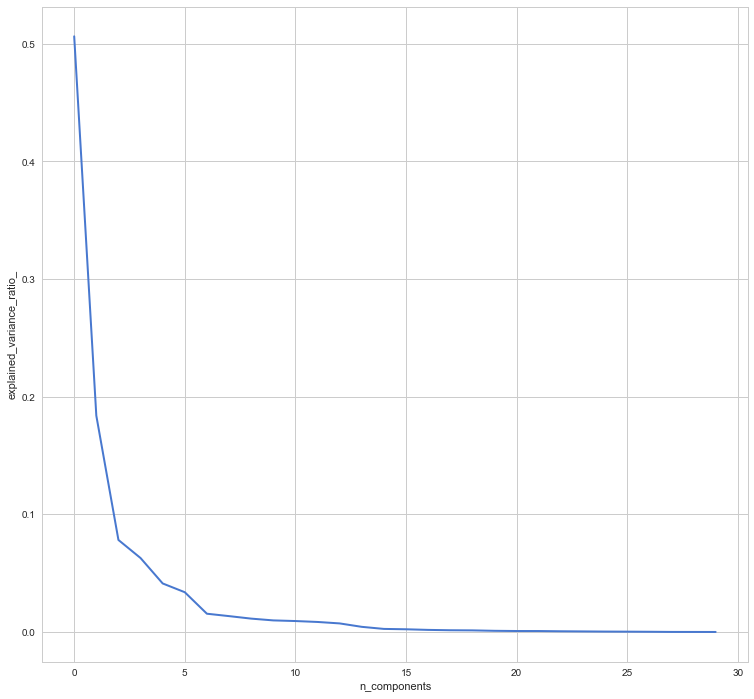

In [85]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
#normalization
x_train_N = (x_train-x_train.mean())/(x_train.max()-x_train.min())
x_test_N = (x_test-x_test.mean())/(x_test.max()-x_test.min())

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train_N)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

# Roc Curve 

In [86]:
import matplotlib.pylab as plt
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.patches as patches
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf8"))

20news-bydate-train
CUST_VIP_demo_origin.csv
Cathay_SNA_demo.csv
MovieGenre.csv
MovieGenre.csv.zip
VS14MORT.txt
balance-scale.csv
births_train.csv
breast.csv
busan.txt
busan_edge.csv
busan_node.csv
credit_count.txt
creditcard.csv
dataconf.txt
dict.txt
event_relation.tsv
final_dict_pd.csv
ginal.csv
international-airline-passengers.csv
liquor.csv
lucy.txt
moviedata.csv
new_final_dict_pd.csv
origin_new.csv
people_event.tsv
planet.csv
series1.csv
test_final.csv
this.csv
this2.csv
titanic.csv
train_users.csv
train_v2.csv
voice.csv
yelp_academic_dataset_review.json



In [87]:
data = pd .read_csv('data/voice.csv')
print(data.columns)
label_value_count = data.label.value_counts()
print(label_value_count)
print(data.info())

Index([u'meanfreq', u'sd', u'median', u'Q25', u'Q75', u'IQR', u'skew', u'kurt',
       u'sp.ent', u'sfm', u'mode', u'centroid', u'meanfun', u'minfun',
       u'maxfun', u'meandom', u'mindom', u'maxdom', u'dfrange', u'modindx',
       u'label'],
      dtype='object')
male      1584
female    1584
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
meanfreq    3168 non-null float64
sd          3168 non-null float64
median      3168 non-null float64
Q25         3168 non-null float64
Q75         3168 non-null float64
IQR         3168 non-null float64
skew        3168 non-null float64
kurt        3168 non-null float64
sp.ent      3168 non-null float64
sfm         3168 non-null float64
mode        3168 non-null float64
centroid    3168 non-null float64
meanfun     3168 non-null float64
minfun      3168 non-null float64
maxfun      3168 non-null float64
meandom     3168 non-null float64
mindom      3168 non-null 

In [88]:
# Convert string label to float : male = 1, female = 0
dict = {'label':{'male':1,'female':0}}      # label = column name
data.replace(dict,inplace = True)           # replace = str to numerical
x = data.loc[:, data.columns != 'label']
y = data.loc[:,'label']

In [89]:
random_state = np.random.RandomState(0)
clf = RandomForestClassifier(random_state=random_state)
cv = StratifiedKFold(n_splits=5,shuffle=False)

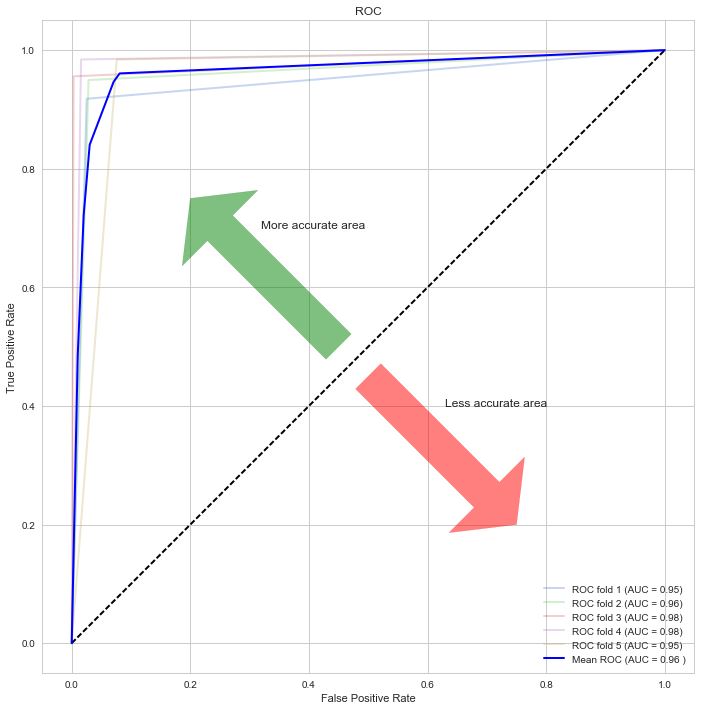

In [90]:
# plot arrows
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
ax1.add_patch(
    patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
    )
ax1.add_patch(
    patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
    )

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction)
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

# KFold交叉驗證法

In [ ]:
from sklearn.cross_validation import StratifiedKFold
import numpy as np
from sklearn.cross_validation import StratifiedKFold

kfold = StratifiedKFold(y=y_train, n_folds=10, random_state = 87)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# Confusion Matrix

In [ ]:
#不論是準確率（Accuracy）、精確率（Precision）或召回率（Recall）都可以由混淆矩陣計算
from sklearn.metrics import confusion_matrix

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(conf_mat)

# 二元分類模型評估

In [ ]:
#sklearn.metrics 的 roc_auc_score()
from sklearn.metrics import roc_auc_score
print('ROC AUC: %.3f' % roc_auc_score(y_true = y_test, y_score = y_pred))

# 多元分類模型評估

In [ ]:
#sklearn.metrics 的 make_scorer()
from sklearn.metrics import make_scorer
pre_scorer = make_scorer(score_func=precision_score, pos_label=1, greater_is_better=True, average='micro')

In [98]:
import numpy as np
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.datasets import imdb

Using TensorFlow backend.


In [105]:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
x_train

(25000, 'train sequences')
(25000, 'test sequences')


array([ list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]),
       list([1, 194, 1153, 194, 2, 78, 228, 5, 6, 1463, 4369

In [106]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

In [107]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
x_train

array([[   0,    0,    0, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ..., 
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)

In [110]:
x_train.shape

(25000, 400)

In [108]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=embedding_dims))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          validation_data=(x_test, y_test))

# stack + unstack

In [111]:
name = ["蒙其·D·魯夫", "羅羅亞·索隆", "娜美", "騙人布", "賓什莫克·香吉士", "多尼多尼·喬巴", "妮可·羅賓", "佛朗基", "布魯克"]
age = [19, 21, 20, 19, 21, 17, 30, 36, 90]
height = [174, 181, 170, 176, 180, 90, 188, 240, 277]

# 建立 dict
straw_hat_dict = {
    "name": name,
    "age": age,
    "height": height
}

# 建立一個寬表格
straw_hat_df_wide = pd.DataFrame(straw_hat_dict)
straw_hat_df_wide

,age,height,name
0,19,174,蒙其·D·魯夫
1,21,181,羅羅亞·索隆
2,20,170,娜美
3,19,176,騙人布
4,21,180,賓什莫克·香吉士
5,17,90,多尼多尼·喬巴
6,30,188,妮可·羅賓
7,36,240,佛朗基
8,90,277,布魯克


In [115]:
# 轉換為長表格
straw_hat_df_long = straw_hat_df_wide.stack()
print(straw_hat_df_long)

# 轉換回寬表格
straw_hat_df_wide = straw_hat_df_long.unstack()
straw_hat_df_wide

0  age             19
   height         174
   name       蒙其·D·魯夫
1  age             21
   height         181
   name        羅羅亞·索隆
2  age             20
   height         170
   name            娜美
3  age             19
   height         176
   name           騙人布
4  age             21
   height         180
   name      賓什莫克·香吉士
5  age             17
   height          90
   name       多尼多尼·喬巴
6  age             30
   height         188
   name         妮可·羅賓
7  age             36
   height         240
   name           佛朗基
8  age             90
   height         277
   name           布魯克
dtype: object


,age,height,name
0,19,174,蒙其·D·魯夫
1,21,181,羅羅亞·索隆
2,20,170,娜美
3,19,176,騙人布
4,21,180,賓什莫克·香吉士
5,17,90,多尼多尼·喬巴
6,30,188,妮可·羅賓
7,36,240,佛朗基
8,90,277,布魯克


In [119]:
# 建立一個有重複值的 data frame
name = ["蒙其·D·魯夫", "蒙其·D·魯夫", "蒙其·D·魯夫", "羅羅亞·索隆", "羅羅亞·索隆", "羅羅亞·索隆"]
age = [19, 19, 17, 21, 21, 19]
duplicated_dict = {
    "name": name,
    "age": age
}
duplicated_df = pd.DataFrame(duplicated_dict)

# 判斷是否重複
print(duplicated_df.duplicated())

# 去除重複觀測值
print(duplicated_df.drop_duplicates())

0    False
1     True
2    False
3    False
4     True
5    False
dtype: bool
   age     name
0   19  蒙其·D·魯夫
2   17  蒙其·D·魯夫
3   21   羅羅亞·索隆
5   19   羅羅亞·索隆


In [125]:
name = ["蒙其·D·魯夫", "羅羅亞·索隆", "娜美", "騙人布", "賓什莫克·香吉士", "多尼多尼·喬巴", "妮可·羅賓", "佛朗基", "布魯克"]
age = [19, 21, 25, 19, 21, 17, 30, 36, 90]

# 建立 dict
straw_hat_dict = {
    "name": name,
    "age": age
}

# 建立一個 data frame
straw_hat_df = pd.DataFrame(straw_hat_dict, columns = ["name", "age"])

# 分箱
bins = [0, 25, float("inf")]
group_names = ["小於 25 歲", "超過 25 歲"]
straw_hat_df.ix[:, "age_cat"] = pd.cut(straw_hat_df.ix[:, "age"], bins, labels = group_names)
straw_hat_df

,name,age,age_cat
0,蒙其·D·魯夫,19,小於 25 歲
1,羅羅亞·索隆,21,小於 25 歲
2,娜美,25,小於 25 歲
3,騙人布,19,小於 25 歲
4,賓什莫克·香吉士,21,小於 25 歲
5,多尼多尼·喬巴,17,小於 25 歲
6,妮可·羅賓,30,超過 25 歲
7,佛朗基,36,超過 25 歲
8,布魯克,90,超過 25 歲
